In [1]:
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import re, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ants

np.random.seed(seed=42) 

In [2]:
# !pip install antspynet

In [2]:
DATADIR = "/DATA/ABCDFixRelease"
TASKDIR = "/DATA/ABCDTasks"

PROCDIR = "/DATA/Users/amahmood/braintyp/"

train_paths = glob.glob(os.path.join(PROCDIR,"train/*"))
val_paths = glob.glob(os.path.join(PROCDIR,"val/*"))

train_paths[:3], len(train_paths), len(val_paths)

(['/DATA/Users/amahmood/braintyp/train/NDARINVVM3WVMV7.nii.gz',
  '/DATA/Users/amahmood/braintyp/train/NDARINV6R35KCYL.nii.gz',
  '/DATA/Users/amahmood/braintyp/train/NDARINV8TUJVDPE.nii.gz'],
 2511,
 321)

In [3]:
import ants, antspynet

def getBbox(data):
    
    x = np.any(data, axis=(1,2)) # Returns true for every nonzero element 
    y = np.any(data, axis=(0,2))
    z = np.any(data, axis=(0,1)) 

    xmin, xmax = x.nonzero()[0][[0, -1]] # (xmin,0,0 to xmax,0,0 )
    ymin, ymax = y.nonzero()[0][[0, -1]]
    zmin, zmax = z.nonzero()[0][[0, -1]]
    
    return np.array([[xmin,ymin,zmin],[xmax,ymax,zmax]])

def checkFaces(img):
    return (np.any(img[:,0,0]) or np.any(img[:,-1,-1])  or
           np.any(img[0,:,0]) or np.any(img[-1,:,-1]) or
           np.any(img[0,0,:]) or np.any(img[-1:,:,]))

In [4]:
img = ants.image_read(train_paths[0])
img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 2
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [6]:
bbox = getBbox(img.numpy()[...,0])
bbox, checkFaces(img[...,0])

(array([[ 23,  20,  19],
        [159, 193, 143]]),
 False)

## Train Samples

In [9]:
%%time
minbbox = np.array([[255,255,255],[0,0,0]])
count = 0
for p in train_paths:
    img = ants.image_read(p).numpy()[...,0]
    bbox = getBbox(img)
    
    if checkFaces(img):
        count += 1
    else:
        minbbox[0,:] = np.min((minbbox[0], bbox[0]), axis=0)
        minbbox[1,:] = np.max((minbbox[1], bbox[1]), axis=0)

print(f"MNI Crop was too tight for {count} cases")
print(f"Min bbox: ({minbbox[0]}), ({minbbox[1]})")

MNI Crop was too tight for 0 cases
Min bbox: ([11  9  0]), ([171 204 151])
CPU times: user 39min 38s, sys: 13min 7s, total: 52min 45s
Wall time: 55min 25s


## Val Paths

In [10]:
%%time
vminbbox = np.array([[255,255,255],[0,0,0]])
count = 0
for p in val_paths:
    img = ants.image_read(p).numpy()[...,0]
    bbox = getBbox(img)
    
    if checkFaces(img):
        count += 1
    else:
        vminbbox[0,:] = np.min((vminbbox[0], bbox[0]), axis=0)
        vminbbox[1,:] = np.max((vminbbox[1], bbox[1]), axis=0)

print(f"MNI Crop was too tight for {count} cases")
print(f"Min bbox: ({vminbbox[0]}), ({vminbbox[1]})")

MNI Crop was too tight for 0 cases
Min bbox: ([13 11  0]), ([168 202 150])
CPU times: user 5min 19s, sys: 1min 51s, total: 7min 11s
Wall time: 7min 34s


In [21]:
minbox = np.concatenate([np.min((minbbox[0], vminbbox[0]), axis=0), np.max((minbbox[1], vminbbox[1]), axis=0)])
minbox, minbox[3:]-minbox[:3]

(array([ 11,   9,   0, 171, 204, 151]), array([160, 195, 151]))

## After New Bbox

In [22]:
%%time
_minbbox = np.array([[255,255,255],[0,0,0]])
count = 0
for p in train_paths:
    img = ants.image_read(p).numpy()[minbox[0]:minbox[3]+1,minbox[1]:minbox[4]+1,minbox[2]:minbox[5]+1,0]
    bbox = getBbox(img)
    
    if checkFaces(img):
        count += 1
    else:
        _minbbox[0,:] = np.min((_minbbox[0], bbox[0]), axis=0)
        _minbbox[1,:] = np.max((_minbbox[1], bbox[1]), axis=0)

print(f"MNI Crop was too tight for {count} cases")
print(f"Min bbox: ({_minbbox[0]}), ({_minbbox[1]})")

MNI Crop was too tight for 2 cases
Min bbox: ([0 0 0]), ([159 195 151])
CPU times: user 42min 4s, sys: 14min 8s, total: 56min 13s
Wall time: 1h 3s


In [64]:
T1_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd")
T2_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd")
MASK_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd")

t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

In [82]:
t1_ref_img, ants_mni

(ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (197, 233, 189)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (-196.0, -232.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 ANTsImage (LPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (182, 218, 182)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.])

In [83]:
bbox1 = getbbox(t1_ref_img.numpy())
bbox2 = getbbox(ants_mni.numpy())
bbox1, bbox2

(array([  0,   0,   0, 196, 232, 188]), array([  0,   0,   0, 181, 217, 181]))

In [92]:
# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1+diff//2, np.array(t1_ref_img.shape)-diff//2
crop_idxs_start, crop_idxs_end

(array([8, 8, 4]), array([190, 226, 186]))

In [96]:
t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end )
t2_ref_img = ants.crop_indices( t2_ref_img, crop_idxs_start, crop_idxs_end )
ref_img_mask =  ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end )

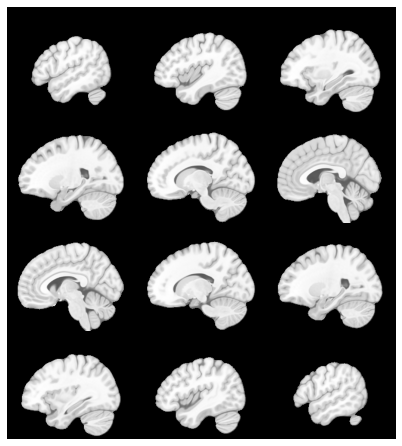

In [97]:
ants.plot(t1_ref_img * ref_img_mask)

In [218]:
stripped = t1_ref_img * ref_img_mask
print(np.any(stripped[:,0,0]) or np.any(stripped[:,-1,-1]))
print(np.any(stripped[0,:,0]) or np.any(stripped[-1,:,-1]))
print(np.any(stripped[0,0,:]) or np.any(stripped[-1:,:,]))

False